<a href="https://colab.research.google.com/github/ThumbRocket/AI_Expert_Lecture_Files/blob/main/5Week/recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Movie Recommendation System with Text Embedding

![Alt text](https://repository-images.githubusercontent.com/275336521/20d38e00-6634-11eb-9d1f-6a5232d0f84f)

## Import requirements

In [1]:
! pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 6.2 MB/s eta 0:00:00


In [2]:
! pip install sentence_transformers ## For textual similarity, using pretrained models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from tqdm.notebook import tqdm
import faiss
from sentence_transformers import SentenceTransformer, util

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load Dataset and Model

In [4]:
imdb_movies=pd.read_csv("https://raw.githubusercontent.com/tommyEzreal/0701_samsung/main/imdb_movies_0626.csv")
imdb_movies

# we will encode 'Description' columnn for our recommendation system

,Unnamed: 0,Movie Name,Year of Release,Watch Time,Movie Rating,Meatscore of movie,Votes,Gross,Description,id,cluster
0,0,The Shawshank Redemption,(1994),142 min,9.3,81,"34,709",$28.34M,Two imprisoned men bond over a number of years...,0,2
1,1,The Godfather,(1972),175 min,9.2,100,"34,709",$134.97M,The aging patriarch of an organized crime dyna...,1,2
2,2,The Dark Knight,(2008),152 min,9.0,84,"34,709",$534.86M,When the menace known as the Joker wreaks havo...,2,2
3,3,The Lord of the Rings: The Return of the King,(2003),201 min,9.0,94,"34,709",$377.85M,Gandalf and Aragorn lead the World of Men agai...,3,0
4,4,Schindler's List,(1993),195 min,9.0,94,"34,709",$96.90M,"In German-occupied Poland during World War II,...",4,7
...,...,...,...,...,...,...,...,...,...,...,...
995,995,Sabrina,(1954),113 min,7.6,72,"34,709",%^%^%^,A playboy becomes interested in the daughter o...,995,1
996,996,From Here to Eternity,(1953),118 min,7.6,85,"34,709",$30.50M,"At a U.S. Army base in 1941 Hawaii, a private ...",996,7
997,997,Snow White and the Seven Dwarfs,(1937),83 min,7.6,95,"34,709",$184.93M,Exiled into the dangerous forest by her wicked...,997,8
998,998,The 39 Steps,(1935),86 min,7.6,93,"34,709",%^%^%^,A man in London tries to help a counter-espion...,998,5


In [5]:
k = 0
print("Movie Title:",imdb_movies['Movie Name'][k])
print("Movie description:", imdb_movies['Description'][k])

Movie Title: The Shawshank Redemption
Movie description: Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.


In [6]:
# load bi-encoder model
model = SentenceTransformer('paraphrase-distilroberta-base-v1') # Loads the distil roberta model,whcih was trained on millions of data

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.78k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/328M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Query-based Recommendation

![Example Image](https://drive.google.com/uc?id=1biO4IGKqeiyChgOBVjqxdnvitBWImGkn)


- `User Query Input`: The user inputs a description or keywords for the movie they want to watch.
- `Query Embedding`: Convert the user's query into an embedding vector. This involves mapping the text into a high-dimensional vector space using a natural language processing model.
- `Movie Description Embeddings`: Similarly, convert each movie description in the dataframe into embedding vectors.
- `Calculating Similarity`:
Compute the cosine similarity between the embedding vector of the user's query and the embedding vectors of all movie descriptions. Cosine similarity measures how similar two vectors are by calculating the cosine of the angle between them.
Recommend the Most Similar Movie: Recommend the movie with the highest similarity score.
- `Recommend the Most Similar Movie` :
Identify the movie with the highest similarity score and recommend it to the user as the best match for their query.



In [7]:
# what is faiss? : reduce the computational cost of calculating embedding similarity
# prior to calculating simialrity, first cluster the index pool -> assign query to most similar cluster , then calculate the similarity in the cluster

def make_faiss_index(df):
    descriptions=df['Description'].tolist()
    print("Number of Movie Description ",len(descriptions))

    # for each movie description, encode and get embeddings
    des_embeddings = []
    for des in tqdm(descriptions):
        des_embeddings.append(model.encode(des))

    # convert the list to a numpy array
    des_embeddings_array = np.array(des_embeddings)
    print("Shape of the EMbeddings is ",des_embeddings_array.shape)

    faiss.normalize_L2(des_embeddings_array) ## Normalising the Embeddings


    dim=768 # we get a 768 dimension vector following the dimension of Roberta
    ncentroids=50 # this is a hyperparameter, and indicates number of clusters to be split into
    m=16 #
    quantiser = faiss.IndexFlatL2(dim)
    index = faiss.IndexIVFPQ (quantiser, dim,ncentroids, m , 8)
    index.train(des_embeddings_array) # this step, will do the clustering and create the clusters
    faiss.write_index(index, "trained.index")

    # add the embeddings to the trained Index.
    ids=df['id'].tolist()
    ids=np.array(ids)
    index.add_with_ids(des_embeddings_array,ids)
    faiss.write_index(index,"block.index")

    return des_embeddings, index

des_embeddings, index = make_faiss_index(imdb_movies)

Number of Movie Description  1000


  0%|          | 0/1000 [00:00<?, ?it/s]

Shape of the EMbeddings is  (1000, 768)


In [17]:
len(des_embeddings), len(des_embeddings[0])

(1000, 768)

In [12]:
# calculate cosine similarity
def calculateInnerProduct(L2_score):
    return (2-math.pow(L2_score,2))/2


def searchFAISSIndex(data,id_col_name,query,index,nprobe,model,topk=10):
    #convert the query into embeddings
    query_embedding=model.encode([query])[0]
    dim=query_embedding.shape[0]
    query_embedding=query_embedding.reshape(1,dim)
    faiss.normalize_L2(query_embedding)

    index.nprobe=nprobe

    D,I=index.search(query_embedding,topk)
    ids=[i for i in I][0]
    L2_score=[d for d in D][0]
    inner_product=[calculateInnerProduct(l2) for l2 in L2_score]

    # visualization
    search_result=pd.DataFrame()
    search_result[id_col_name]=ids
    search_result['cosine_sim']=inner_product
    dat=data[data[id_col_name].isin(ids)]
    dat=pd.merge(dat,search_result,on=id_col_name)
    dat=dat.sort_values('cosine_sim',ascending=False)

    return dat, query_embedding

In [13]:
# use your own query !

query="Super Hero movie"
search_result, query_embedding =searchFAISSIndex(imdb_movies,"id",query,index,nprobe=10,model=model,topk=10)
search_result=search_result[['id','Description','Movie Name','cosine_sim']]
search_result

,id,Description,Movie Name,cosine_sim
6,367,Earth's mightiest heroes must come together an...,The Avengers,0.464363
8,605,"In a time of conflict, a group of unlikely her...",Rogue One: A Star Wars Story,0.433408
4,280,In this luminous tale set in the area around S...,Time of the Gypsies,0.426381
1,64,Teen Miles Morales becomes the Spider-Man of h...,Spider-Man: Into the Spider-Verse,0.425828
2,65,After the devastating events of Avengers: Infi...,Avengers: Endgame,0.417640
0,2,When the menace known as the Joker wreaks havo...,The Dark Knight,0.412716
5,359,Determined to ensure Superman's ultimate sacri...,Zack Snyder's Justice League,0.402233
3,66,The Avengers and their allies must be willing ...,Avengers: Infinity War,0.400378
9,876,"With the assistance of the Enterprise crew, Ad...",Star Trek II: The Wrath of Khan,0.392874
7,441,A crafty samurai helps a young man and his fel...,Sanjuro,0.384667


In [14]:
query="Recommend me a romantic comedy"
search_result, query_embedding=searchFAISSIndex(imdb_movies,"id",query,index,nprobe=10,model=model,topk=10)
search_result=search_result[['id','Description','Movie Name','cosine_sim']]
search_result

,id,Description,Movie Name,cosine_sim
2,339,"While navigating their careers in Los Angeles,...",La La Land,0.209603
4,485,An egomaniacal film star develops a relationsh...,The Artist,0.192227
3,401,Two melancholy Hong Kong policemen fall in lov...,Chungking Express,0.184158
9,843,A simple Italian postman learns to love poetry...,The Postman,0.176874
7,720,"In 1910s London, snobbish phonetics professor ...",My Fair Lady,0.161796
8,756,A washed-up superhero actor attempts to revive...,Birdman or (The Unexpected Virtue of Ignorance),0.159508
1,220,Six short stories that explore the extremities...,Wild Tales,0.156316
5,495,A depressed wealthy businessman finds his life...,Jab We Met,0.145009
0,125,A New York City advertising executive goes on ...,North by Northwest,0.142428
6,516,Two men share an odd friendship while they car...,Talk to Her,0.128067


In [15]:
query="Kids Animation"
search_result, query_embedding=searchFAISSIndex(imdb_movies,"id",query,index,nprobe=10,model=model,topk=10)
search_result=search_result[['id','Description','Movie Name','cosine_sim']]
search_result

,id,Description,Movie Name,cosine_sim
0,60,While serving a five-year sentence for a viole...,Capernaum,0.354904
5,373,"In a small Tokyo apartment, twelve-year-old Ak...",Nobody Knows,0.291275
1,104,The toys are mistakenly delivered to a day-car...,Toy Story 3,0.280464
2,111,A cowboy doll is profoundly threatened and jea...,Toy Story,0.268276
6,395,"A baby boy, discovered in 1900 on an ocean lin...",The Legend of 1900,0.262176
7,751,"Due to 12 y.o. Anna's asthma, she's sent to st...",When Marnie Was There,0.252381
4,176,A pragmatic paleontologist touring an almost c...,Jurassic Park,0.231739
8,854,An examination of the machinations behind the ...,Glengarry Glen Ross,0.225549
3,152,The youngest son of an alcoholic former boxer ...,Warrior,0.219455
9,989,Bagheera the Panther and Baloo the Bear have a...,The Jungle Book,0.215666


### embedding visualization

<ipython-input-20-d4f1ec2e53e4>:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_results[len(embeddings1), 0], tsne_results[len(embeddings1), 1], c=palette[0], marker='X', s=200, label=query1)
<ipython-input-20-d4f1ec2e53e4>:36: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_results[len(embeddings1) + 1 + len(embeddings2), 0], tsne_results[len(embeddings1) + 1 + len(embeddings2), 1], c=palet

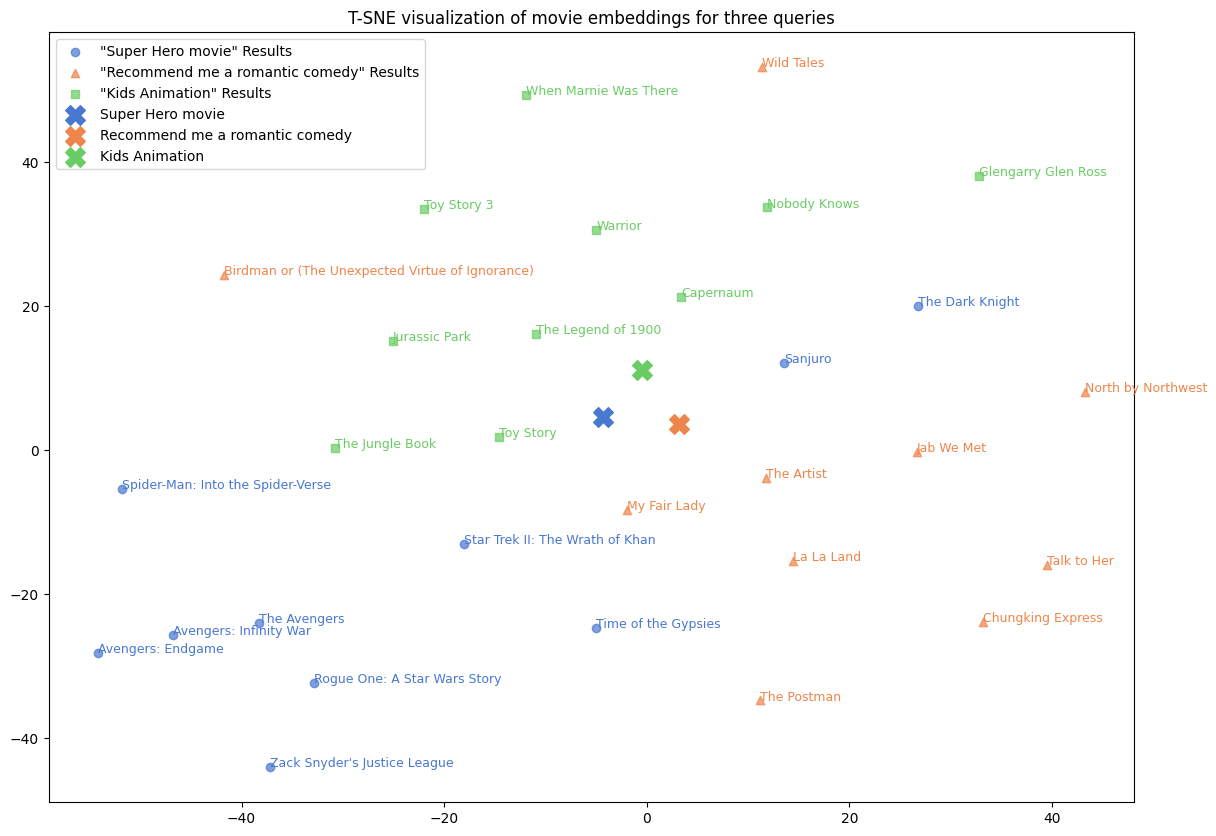

In [20]:
# Visualize embeddings using T-SNE
def visualize_embeddings_3queries(data1, embeddings1, query_embedding1, data2, embeddings2, query_embedding2, data3, embeddings3, query_embedding3, query1, query2, query3, perplexity=5):
    # Combine the embeddings
    combined_embeddings = np.vstack([embeddings1, query_embedding1, embeddings2, query_embedding2, embeddings3, query_embedding3])

    # Apply T-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_results = tsne.fit_transform(combined_embeddings)

    # Generate colors
    palette = sns.color_palette("muted", 3)

    # Plot the results
    plt.figure(figsize=(14, 10))

    # Plot the first query results
    scatter1 = plt.scatter(
        tsne_results[:len(embeddings1), 0], tsne_results[:len(embeddings1), 1],
        color=palette[0], label=f'"{query1}" Results', alpha=0.7, marker='o'
    )

    # Plot the second query results
    scatter2 = plt.scatter(
        tsne_results[len(embeddings1) + 1:len(embeddings1) + 1 + len(embeddings2), 0], tsne_results[len(embeddings1) + 1:len(embeddings1) + 1 + len(embeddings2), 1],
        color=palette[1], label=f'"{query2}" Results', alpha=0.7, marker='^'
    )

    # Plot the third query results
    scatter3 = plt.scatter(
        tsne_results[len(embeddings1) + 1 + len(embeddings2) + 1:-1, 0], tsne_results[len(embeddings1) + 1 + len(embeddings2) + 1:-1, 1],
        color=palette[2], label=f'"{query3}" Results', alpha=0.7, marker='s'
    )

    # Highlight the query points
    plt.scatter(tsne_results[len(embeddings1), 0], tsne_results[len(embeddings1), 1], c=palette[0], marker='X', s=200, label=query1)
    plt.scatter(tsne_results[len(embeddings1) + 1 + len(embeddings2), 0], tsne_results[len(embeddings1) + 1 + len(embeddings2), 1], c=palette[1], marker='X', s=200, label=query2)
    plt.scatter(tsne_results[-1, 0], tsne_results[-1, 1], c=palette[2], marker='X', s=200, label=query3)

    # Annotate the points with movie names
    for i, txt in enumerate(data1['Movie Name']):
        plt.text(tsne_results[i, 0], tsne_results[i, 1], txt, fontsize=9, color=palette[0])

    for i, txt in enumerate(data2['Movie Name']):
        plt.text(tsne_results[len(embeddings1) + 1 + i, 0], tsne_results[len(embeddings1) + 1 + i, 1], txt, fontsize=9, color=palette[1])

    for i, txt in enumerate(data3['Movie Name']):
        plt.text(tsne_results[len(embeddings1) + 1 + len(embeddings2) + 1 + i, 0], tsne_results[len(embeddings1) + 1 + len(embeddings2) + 1 + i, 1], txt, fontsize=9, color=palette[2])

    plt.legend()
    plt.title('T-SNE visualization of movie embeddings for three queries')
    plt.show()

# Example usage
query1 = "Super Hero movie"
query2 = "Recommend me a romantic comedy"
query3 = "Kids Animation"

# Search results for query 1
search_result1, query_embedding1 = searchFAISSIndex(imdb_movies, "id", query1, index, nprobe=10, model=model, topk=10)
search_result1 = search_result1[['id', 'Description', 'Movie Name', 'cosine_sim']]
embeddings1 = np.array([model.encode([desc])[0] for desc in search_result1['Description'].tolist()])

# Search results for query 2
search_result2, query_embedding2 = searchFAISSIndex(imdb_movies, "id", query2, index, nprobe=10, model=model, topk=10)
search_result2 = search_result2[['id', 'Description', 'Movie Name', 'cosine_sim']]
embeddings2 = np.array([model.encode([desc])[0] for desc in search_result2['Description'].tolist()])

# Search results for query 3
search_result3, query_embedding3 = searchFAISSIndex(imdb_movies, "id", query3, index, nprobe=10, model=model, topk=10)
search_result3 = search_result3[['id', 'Description', 'Movie Name', 'cosine_sim']]
embeddings3 = np.array([model.encode([desc])[0] for desc in search_result3['Description'].tolist()])

# Visualize with adjusted perplexity
visualize_embeddings_3queries(search_result1, embeddings1, query_embedding1, search_result2, embeddings2, query_embedding2, search_result3, embeddings3, query_embedding3, query1, query2, query3, perplexity=5)


## User Histroy-based Recommendation



![Example Image](https://drive.google.com/uc?id=16dw0Ud2-Wui62WJ4ZHRoYb6XRpR58ecr)

- `User Viewing History Input`:
The system accesses the user's viewing history, which includes descriptions of all the movies the user has watched.

- `Movie Description Embeddings`: Convert each movie description in the user's viewing history into embedding vectors using a pre-trained language model (e.g., BERT).
- `User Embedding`: Calculate the average of all movie description embeddings from the user's viewing history to create a single embedding vector representing the user's overall movie preferences.
- `Calculating Similarity`:
Calculate the cosine similarity between the user's embedding vector and the embedding vectors of all movies in the database. Cosine similarity measures the cosine of the angle between two vectors, indicating how similar the vectors are. A similarity score closer to 1 means the vectors are more similar.
- `Recommend Movies`:
Identify the movies with the highest similarity scores and recommend them to the user as the best matches for their viewing history and preferences.

In [21]:
imdb_movies

,Unnamed: 0,Movie Name,Year of Release,Watch Time,Movie Rating,Meatscore of movie,Votes,Gross,Description,id,cluster
0,0,The Shawshank Redemption,(1994),142 min,9.3,81,"34,709",$28.34M,Two imprisoned men bond over a number of years...,0,2
1,1,The Godfather,(1972),175 min,9.2,100,"34,709",$134.97M,The aging patriarch of an organized crime dyna...,1,2
2,2,The Dark Knight,(2008),152 min,9.0,84,"34,709",$534.86M,When the menace known as the Joker wreaks havo...,2,2
3,3,The Lord of the Rings: The Return of the King,(2003),201 min,9.0,94,"34,709",$377.85M,Gandalf and Aragorn lead the World of Men agai...,3,0
4,4,Schindler's List,(1993),195 min,9.0,94,"34,709",$96.90M,"In German-occupied Poland during World War II,...",4,7
...,...,...,...,...,...,...,...,...,...,...,...
995,995,Sabrina,(1954),113 min,7.6,72,"34,709",%^%^%^,A playboy becomes interested in the daughter o...,995,1
996,996,From Here to Eternity,(1953),118 min,7.6,85,"34,709",$30.50M,"At a U.S. Army base in 1941 Hawaii, a private ...",996,7
997,997,Snow White and the Seven Dwarfs,(1937),83 min,7.6,95,"34,709",$184.93M,Exiled into the dangerous forest by her wicked...,997,8
998,998,The 39 Steps,(1935),86 min,7.6,93,"34,709",%^%^%^,A man in London tries to help a counter-espion...,998,5


In [22]:
def make_user_history(df):

    user_ids = sorted(df['cluster'].unique())

    user_history = {}
    for user_id in user_ids:
        # synthetic user history
        description_list = df[df['cluster']==user_id]['Description'].tolist()[:50]
        movie_name_list = df[df['cluster']==user_id]['Movie Name'].tolist()[:50]
        ids = df[df['cluster']==user_id]['id'].tolist()[:50]
        user_history[f'user_{user_id}'] = {'Movie Name': movie_name_list, "Description": description_list, "id": ids}

        #prediction_pool
        indices_to_drop = df[df['id'].isin(ids)].index
        prediction_pool = df.drop(indices_to_drop)
        user_history[f'user_{user_id}']['pred_pool'] = prediction_pool

        #GT
        GT_description = df[df['cluster']==user_id]['Description'].tolist()[50:]
        GT_movie_name = df[df['cluster']==user_id]['Movie Name'].tolist()[50:]

        user_history[f'user_{user_id}']['GT'] = [(d, n) for d,n in zip(GT_description, GT_movie_name)]

    return user_history

user_history = make_user_history(imdb_movies)

In [23]:
user_history['user_6']['Movie Name']

['Inception',
 'The Matrix',
 "One Flew Over the Cuckoo's Nest",
 'Top Gun: Maverick',
 "It's a Wonderful Life",
 'Whiplash',
 'The Intouchables',
 'Back to the Future',
 'Joker',
 'Coco',
 'Amadeus',
 'Witness for the Prosecution',
 'The Hunt',
 'Spider-Man: No Way Home',
 'Good Will Hunting',
 'Once Upon a Time in America',
 'A Clockwork Orange',
 'The Apartment',
 'Vertigo',
 'Pather Panchali',
 'Ikiru',
 'Andhadhun',
 'Green Book',
 'The Secret in Their Eyes',
 'The Wolf of Wall Street',
 'A Beautiful Mind',
 'The Truman Show',
 'The Elephant Man',
 'Taxi Driver',
 'Sherlock Jr.',
 'A Silent Voice: The Movie',
 'OMG: Oh My God!',
 'The Grand Budapest Hotel',
 'Gone Girl',
 'A Wednesday',
 'Into the Wild',
 'Munna Bhai M.B.B.S.',
 'Trainspotting',
 'Groundhog Day',
 'Time of the Gypsies',
 'Paris, Texas',
 'Rocky',
 'Network',
 'Anand',
 'Cool Hand Luke',
 'Wild Strawberries',
 'Throne of Blood',
 'On the Waterfront',
 'Ace in the Hole',
 'Mr. Smith Goes to Washington']

In [24]:
prediction_pool_df = user_history['user_6']['pred_pool']

prediction_pool_df=prediction_pool_df.reset_index(drop=True)
prediction_pool_df['id']=prediction_pool_df.index

pool_embeddings, index = make_faiss_index(prediction_pool_df)

Number of Movie Description  950


  0%|          | 0/950 [00:00<?, ?it/s]

Shape of the EMbeddings is  (950, 768)


In [25]:
def make_user_embedding(user_history):
    ## Convert the list of user history into embeddings
    user_embeddings = [model.encode([hist])[0] for hist in tqdm(user_history)]
    print(user_embeddings[0].shape)

    ## Calculate the mean of the embeddings
    # 모든 임베딩을 평균 냄
    avg_user_embedding = np.mean(user_embeddings, axis=0) ## FILL ##
    print(avg_user_embedding.shape)

    return avg_user_embedding

In [26]:
user_history_sample = user_history['user_6']['Description']
sample_embedding = make_user_embedding(user_history_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

(768,)
(768,)


In [29]:
def searchFAISSIndex_user_history(data, id_col_name, user_history, index, nprobe, model, topk=50):

    avg_user_embedding = make_user_embedding(user_history)

    # Reshape the average query embedding
    dim = avg_user_embedding.shape[0]
    avg_user_embedding = avg_user_embedding.reshape(1, dim)

    # Normalize the query embedding
    faiss.normalize_L2(avg_user_embedding)

    # Set the nprobe parameter
    index.nprobe = nprobe

    # Perform the search
    D, I = index.search(avg_user_embedding, topk)

    # Extract IDs and L2 scores
    ids = [i for i in I][0]
    L2_score = [d for d in D][0]

    # Calculate cosine similarities
    inner_product = [calculateInnerProduct(l2) for l2 in L2_score]

    # Visualization
    search_result = pd.DataFrame()
    search_result[id_col_name] = ids
    search_result['cosine_sim'] = inner_product
    dat = data[data[id_col_name].isin(ids)]
    dat = pd.merge(dat, search_result, on=id_col_name)
    dat = dat.sort_values('cosine_sim', ascending=False)

    return dat, avg_user_embedding

In [30]:
user_history_input = user_history['user_6']['Description']
recommend_pool = user_history['user_6']['pred_pool']

search_result, avg_user_embedding=searchFAISSIndex_user_history(recommend_pool,"id",user_history_input,index,nprobe=10,model=model,topk=20)
search_result=search_result[['id','Description','Movie Name','cosine_sim']]
search_result

  0%|          | 0/50 [00:00<?, ?it/s]

(768,)
(768,)


,id,Description,Movie Name,cosine_sim
5,590,A film crew goes to a tropical island for an e...,King Kong,0.819852
12,786,Two eighth-graders start to have feelings for ...,Flipped,0.813159
19,944,Two Boston area detectives investigate a littl...,Gone Baby Gone,0.810841
16,879,A man afraid to fly must ensure that a plane l...,Airplane!,0.805102
2,353,"In a near future, a lonely writer develops an ...",Her,0.791331
11,782,"Through the innocent eyes of Bruno, the eight-...",The Boy in the Striped Pajamas,0.786795
3,444,A series of stories following a week in the li...,La dolce vita,0.786691
17,888,A pair of NYPD detectives in the Narcotics Bur...,The French Connection,0.776974
13,813,When her grandson is kidnapped during the Tour...,The Triplets of Belleville,0.776490
18,925,"Shot documentary-style, this film follows the ...",End of Watch,0.774464


In [31]:
gts = user_history['user_6']['GT']
gt_movie_names = [tpl[1] for tpl in gts]
pred_movie_names = search_result['Movie Name'].to_list()

count = 0
for pred in pred_movie_names:
    if pred in gt_movie_names:
        count += 1
        print(pred)

Airplane!
The Nightmare Before Christmas


### Manual User history

In [32]:
# manually input your movie preferences !

user_history_input = [
    "animation",
    "fantasy",
    "pixar",
    "ghibli"
    ]


In [33]:
search_result, _=searchFAISSIndex_user_history(recommend_pool,"id",user_history_input,index,nprobe=10,model=model,topk=20)
search_result=search_result[['id','Description','Movie Name','cosine_sim']]
search_result

  0%|          | 0/4 [00:00<?, ?it/s]

(768,)
(768,)


,id,Description,Movie Name,cosine_sim
6,250,A rat who can cook makes an unusual alliance w...,Ratatouille,0.331638
17,946,"A profile of Ian Curtis, the enigmatic singer ...",Control,0.302283
18,949,"In 1985 where former superheroes exist, the mu...",Watchmen,0.293645
12,804,A faded movie star and a neglected young woman...,Lost in Translation,0.266942
2,77,A man with short-term memory loss attempts to ...,Memento,0.253603
5,176,A pragmatic paleontologist touring an almost c...,Jurassic Park,0.232798
0,10,While Frodo and Sam edge closer to Mordor with...,The Lord of the Rings: The Two Towers,0.224481
4,118,Two grifters team up to pull off the ultimate ...,The Sting,0.220740
8,310,"A young boy, left without attention, delves in...",The 400 Blows,0.216375
13,815,The story of 160 elite U.S. soldiers who dropp...,Black Hawk Down,0.213513


In [34]:
user_history_input = [
    "science",
    "alien",
    "spaceship",
    "portal"
    ]

In [35]:
search_result, _=searchFAISSIndex_user_history(recommend_pool,"id",user_history_input,index,nprobe=10,model=model,topk=20)
search_result=search_result[['id','Description','Movie Name','cosine_sim']]
search_result

  0%|          | 0/4 [00:00<?, ?it/s]

(768,)
(768,)


,id,Description,Movie Name,cosine_sim
16,949,"In 1985 where former superheroes exist, the mu...",Watchmen,0.326260
7,376,When two brothers are forced to fight in the K...,Tae Guk Gi: The Brotherhood of War,0.301175
4,250,A rat who can cook makes an unusual alliance w...,Ratatouille,0.294353
9,393,A pop singer gives up her career to become an ...,Perfect Blue,0.281662
5,276,A man's coerced confession to an I.R.A. bombin...,In the Name of the Father,0.275292
6,361,A noble family becomes embroiled in a war for ...,Dune,0.265930
8,385,"While trying to lead a quiet suburban life, a ...",The Incredibles,0.260186
1,118,Two grifters team up to pull off the ultimate ...,The Sting,0.258735
14,573,Disturbed Blanche DuBois moves in with her sis...,A Streetcar Named Desire,0.249112
2,176,A pragmatic paleontologist touring an almost c...,Jurassic Park,0.241513
